In [170]:
using GLM
using DataFrames
using Random
using Parquet
import YAML
using Plots
using CSV
import OrderedCollections: OrderedDict
using StatsBase
import Term: tprintln

using MyterialColors
import MyterialColors: blue

# import Pkg
# Pkg.add(url="https://github.com/JuliaPlots/VennEuler.jl.git")
using VennEuler

colors = OrderedDict(
    "complete" => "black",
    "missing_s" => teal_dark,
    "missing_curv_0cm" => teal,
    "missing_curv_10cm" => teal,
    "missing_curv_20cm" => teal,
    "missing_curv_30cm" => teal,
    "missing_curv_class" =>  teal_light,
    "missing_domega_1000ms" => indigo_dark,
    "missing_domega_500ms" => indigo_dark,
    "missing_domega_250ms" => indigo_dark,
    "missing_omega" => blue,
    "missing_omega_squared" => blue,
    "missing_omega_class" => blue_light,
    "missing_dv_1000ms" => pink_dark,
    "missing_dv_500ms" => pink_dark,
    "missing_dv_250ms" => pink_dark,
    "missing_v" => pink,
    "missing_v_squared" => pink,
    "missing_speed_class" => salmon_dark,

)


include(raw"C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\ephys\glm\glm_utils.jl");

## Load GLM results
Load metadata of which cells were ran and their correlations

In [2]:
fitted = filter(kv -> kv.second["glm_fitted"], metadata)
@info "Fitted $(length(fitted))/$(length(metadata)) units"

formulas = generate_formulas()

for (k,v) in fitted
    # get the pearson correlations
    v["correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "correlations.csv")
    ))

    # get the correlations of the shuffled data
    v["shuffled_correlations"] = DataFrame(CSV.File(
        joinpath(v["folder"], "shuffled_correlations.csv")
    ))

    # get a `FittedModel`
    try
        v["model"] = load_fitted(v, "complete", formulas)
    catch
        v["model"] = nothing
    end
end

nomodel = filter(kv -> isnothing(kv.second["model"]), fitted) |> keys |> collect
length(nomodel) > 0 && @info "No model fitted for $(length(nomodel)) units - revise metadata";

@Info (Main):  Fitted 414/475 units 
  ╰──────────────────────────────────────────────── 
                      Sat, 18 Jun 2022 18:33:29 


## Identify tuned
Look for units whose pearson correlation in the full mode is above the 99th CI of the shuffled correlations

In [53]:
for (k, unit) in fitted
    cbest = mean(unit["correlations"][:, "complete"])
    cshuff = mean.(eachcol(unit["shuffled_correlations"]))
    threshold = percentile(cshuff, 99.9) 

    unit["correlation_threshold"]  = threshold
    unit["tuned"] = cbest > threshold
end

tuned = filter(kv -> kv.second["tuned"], fitted)
tuned = OrderedDict(sort(collect(tuned), by = kv->kv.second["best_corr"]))
@info "Tuned $(length(tuned))/$(length(fitted)) units"

@Info (Main):  Tuned 202/414 units 
  ╰──────────────────────────────────────────────── 
                      Sun, 19 Jun 2022 10:43:07 


plot a single tuned unit

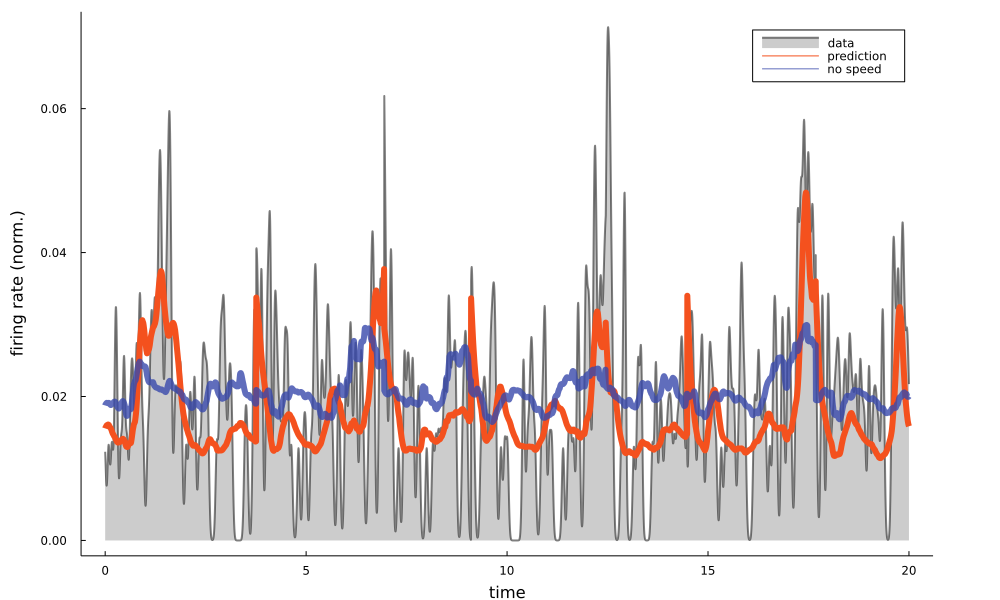

In [440]:
unit = collect(values(tuned))[end-5]
unit_data = load_data(unit)

nov_model = load_fitted(unit, "missing_speed_class")
ŷ_nov = predict(nov_model, unit_data)

# nov_model = load_fitted(unit, "missing_omega_class")
# ŷ_nov = predict(nov_model, unit_data)

x = load_data(unit["model"])
ŷ = predict(unit["model"], x)
y = x.p_spike

t0 = 30_001
t1 = t0 + 4_000

time = collect(0:(t1-t0)) / 200  # time in seconds

plot(ylabel="firing rate (norm.)", xlabel="time", size=(1000, 600), grid=false,
left_margin = 5Plots.mm, right_margin = 15Plots.mm,
)
plot!(time,  y[t0:t1], fillrange =0, fillcolor=:black, fillalpha=.2, color="black", lebel="data", alpha=.5, lw=2, label="data")
plot!(time,  ŷ[t0:t1], lw=6, label="prediction", color=salmon_dark)
plot!(time,  ŷ_nov[t0:t1], lw=6, alpha=.8, label="no speed", color=indigo_dark)

# for i in 1:10:100
#     shuffled_model = load_fitted(unit, i)
#     shuffled_ŷ =  predict(shuffled_model, unit_data)
#     plot!(time,  shuffled_ŷ[t0:t1], lw=4, label=i == 1 ? "shuffled" : nothing, alpha=.5, color="black")
# end
# plot!()


## Variables tuning

Start by plotting for a unit the pearson correlation of each model and compare it to the full model.

D:\Dropbox (UCL)\Rotation_vte\Locomotion\analysis\ephys\GLM\FC_220410_BAA1101192_hairpin_unit_100


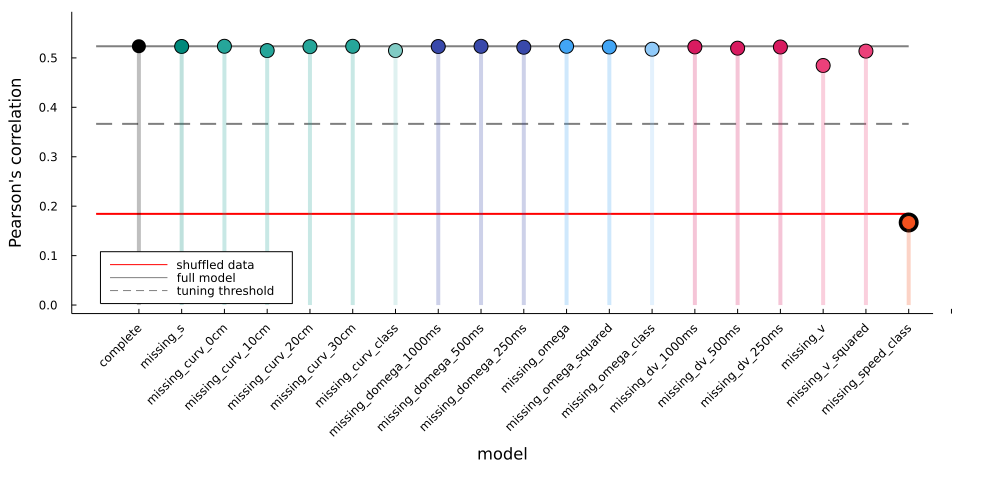

In [412]:
unit = collect(values(tuned))[end-5]
println(unit["folder"])

mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))
tuning_th = max(.7 * mean_corr["complete"], unit["correlation_threshold"])

plot()

# plot lines
plot!([0, length(mean_corr)], [unit["correlation_threshold"], unit["correlation_threshold"]], color="red", lw=2, label="shuffled data")
plot!([0, length(mean_corr)], [mean_corr["complete"], mean_corr["complete"]], color="black", alpha=.5, lw=2, label="full model")
plot!([0, length(mean_corr)], [tuning_th, tuning_th], color="black", linestyle=:dash, alpha=.5, lw=2, label="tuning threshold")


for (i, model) in enumerate(keys(colors))
    corr = mean_corr[model]
    istuned = corr <= tuning_th

    istuned && scatter!([i], [corr], color="black", alpha=1, ms=12, label=nothing)
    scatter!([i], [corr], color=colors[model], alpha=1, ms=8, label=nothing)
    plot!(
        [i, i],
        [0, corr],
        color=colors[model],
        alpha=.25,
        lw=4,
        label=nothing
    )
end

plot!(   
    xticks = (
        1:length(mean_corr)+1,
        keys(colors)
    ), 
    xrotation = 45,
    ylabel = "Pearson's correlation",
    xlabel = "model",
    grid=false,
    ylim=[0, 1.1 * mean_corr["complete"]],
    # legend=false,
    size=(1000, 500),
    left_margin = 5Plots.mm, right_margin = 15Plots.mm,
    bottom_margin = 25Plots.mm,
    legend=:bottomleft
    )

Get all tuning for all units

In [422]:
variables_tuning = Dict{String, Vector{Bool}}(k => [] for k in keys(colors))

for (name, unit) in tuned
    # get mean pearson correlation of each model and threshold
    mean_corr = OrderedDict(k => v for (k,v) in zip(names(unit["correlations"]), mean.(eachcol(unit["correlations"]))))
    tuning_th = max(.8 * mean_corr["complete"], unit["correlation_threshold"])
    
    # get which models are tuned
    for model in keys(colors)    
        corr = mean_corr[model]
        push!(variables_tuning[model],  corr <= tuning_th)
    end
end

variables_tuning = DataFrame(variables_tuning)

,complete,missing_curv_0cm,missing_curv_10cm,missing_curv_20cm,missing_curv_30cm
,Bool,Bool,Bool,Bool,Bool
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,1,1,1,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,0,0
9,0,0,0,0,0


In [423]:
ntuned_var = Dict(k=>sum(variables_tuning[:, k]) for k in keys(colors))
var_classes = ["missing_curv_class", "missing_omega_class", "missing_speed_class"]
classes_names = ["Position/curvature class", "angular velocity class", "speed class"]
# get percentage of units tuned to each class of variables
for (n, var) in zip(classes_names, var_classes)
    # print number of units tuned to class vs total
    ntuned = ntuned_var[var]
    ntotal = length(tuned)
    tprintln("{green}$(ntuned){/green}/$(ntotal) ($(round(ntuned/ntotal * 100; digits=2))%) units tuned to {bold white}$(n){/bold white}";)
end

36/202 (17.82%) units tuned to Position/curvature class 
35/202 (17.33%) units tuned to angular velocity class 
168/202 (83.17%) units tuned to speed class 


get how many units are tuned to > 1 class of variables

In [424]:
# get which units are tuned to more than one class
n_variablesclass_per_unit = Dict{Any, Any}(
    i => 0 for i in 1:3
)
# n_variablesclass_per_unit["tot"] = 0

for unit in eachrow(variables_tuning)
    nvars = sum(values(unit[var_classes]))
    nvars > 0 && (n_variablesclass_per_unit[nvars] += 1)
    # nvars > 0 && (n_variablesclass_per_unit["tot"] += 1)
end
n_variablesclass_per_unit

╭──── Dict {Any, Any}  ────────────────╮
│                                      │
│     {Int64} │ 2 => 25  │ {Int64}     │
│     {Int64} │ 3 => 13  │ {Int64}     │
│     {Int64} │ 1 => 150 │ {Int64}     │
│                                      │
╰────────────────────────── 3 items ───╯


In [425]:
# using VennEuler

# x = Matrix(values(variables_tuning[:, var_classes]))

# classes = map(
#     c -> split(c, "_")[2], var_classes
# )
# eo = make_euler_object(classes, x, EulerSpec(:circle), sizesum=0.5)
# loss, state, result = optimize(eo, random_state(eo))

# render("three-circles.svg", eo, state)

Get how many units are tuned to `speed`, `omega` and spatial info.

In [441]:
import OrderedCollections: OrderedDict
import Term: Table
import Term: highlight

N = size(variables_tuning, 1)
count_perc(x) = highlight("$(x)/$(N) ($(round(x/N * 100; digits=2))%)")

tb(x) = Table(
    x;
    header_style="bold white on_black",
    box=:NONE, style="blue"
)

classes = ["missing_v", "missing_v_squared", "missing_dv_250ms", "missing_dv_500ms", "missing_dv_1000ms"]
cnames = ["speed", "speed²", "Δv 250ms", "Δv 500ms", "Δv 1000ms"]


V = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb

                                                                                               
        speed              speed²           Δv 250ms          Δv 500ms          Δv 1000ms      
                                                                                               
   27/202 (13.37%)     10/202 (4.95%)     3/202 (1.49%)     7/202 (3.47%)     10/202 (4.95%)   
                                                                                               


In [442]:
classes = ["missing_omega", "missing_omega_squared", "missing_domega_250ms", "missing_domega_500ms", "missing_domega_1000ms"]
cnames = ["ang. velocity","ω²", "Δω 250ms", "Δω 500ms", "Δω 1000ms"]

O = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb

                                                                                         
   ang. velocity           ω²             Δω 250ms         Δω 500ms        Δω 1000ms     
                                                                                         
   10/202 (4.95%)     2/202 (0.99%)     1/202 (0.5%)     0/202 (0.0%)     1/202 (0.5%)   
                                                                                         


In [443]:
classes = ["missing_s", "missing_curv_0cm", "missing_curv_10cm", "missing_curv_20cm", "missing_curv_30cm"]
cnames = ["arena location", "curvature at 0 cm", "curvature at 10 cm", "curvature at 20 cm", "curvature at 30 cm"]

K = OrderedDict(
    n => count_perc(sum(variables_tuning[:, k])) for (n, k) in zip(cnames, classes)
) |> tb

                                                                                                               
   arena location     curvature at 0 cm     curvature at 10 cm     curvature at 20 cm     curvature at 30 cm   
                                                                                                               
   18/202 (8.91%)       6/202 (2.97%)         4/202 (1.98%)          6/202 (2.97%)          5/202 (2.48%)      
                                                                                                               


In [469]:
hLine

    ╭─────────────────────────────────────────────────────────────────────────╮
    │                                                                         │
    │                hLine <: Term.Layout.AbstractLayoutElement               │
    │                  │segments ::Vector                                     │
    │                  │ measure ::Term.Measures.Measure                      │
    │                                                                         │
    ╰─────────────────────────────────────────────────────────────────────────╯
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Docstring ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    ┌──────────────────────────────────────────────────────────────────────────┐
    │  hLine                                                                   │
    └──────────────────────────────────────────────────────────────────────────┘

A 1-line renderable made of repeated character from a Box.

    ┌──────────────────────────────────────────────────

In [478]:
import Term: Panel, hLine

Panel(
    Panel(V; fit=false, width=120, title="SPEED", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(130; box=:HEAVY), "",
    Panel(O; fit=false, width=120, title="ANGULAR VELOCITY", title_style="bold red", title_justify=:center, justify=:center, box=:NONE), 
    hLine(130; box=:HEAVY), "",
    Panel(K; fit=false, width=120, title="POSITION", title_style="bold red", title_justify=:center, justify=:center, box=:NONE);
    fit=false, width=140, justify=:center
)

╭──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                              SPEED                                                                       │
│                                                                                                                                          │
│                        speed              speed²           Δv 250ms          Δv 500ms          Δv 1000ms                                 │
│                                                                                                                                          │
│                   27/202 (13.37%)     10/202 (4.95%)     3/202 (1.49%)     7/202 (3.47%)     10/202 (4.95%)                              │
│                                                                                                                                          │
│            